In [94]:
import pandas as pd
from prophet import Prophet

import warnings

TO DO:

- point to right data set -x 
- clean the correct columns in the new data -x

unemployment_rates, 
active_listing_count, 
median_days_on_market, 
5,15,30 interest rates, 
population by county, 
quarterly gdp, 
personal_income_per_capita_state_quarterly


- add regressors to prophet model
- run model
- evaluate model for one county
- expand evaluation to evaluate for all counties (determine one year forecast of most recent data)
- find average MSE or something 

Prophet Notes:

- https://towardsdatascience.com/forecast-model-tuning-with-additional-regressors-in-prophet-ffcbf1777dda 
     -Regressor value must be known in the past and in the future, this is how it helps Prophet to adjust the forecast. The future value must be either predefined and known (for example, a specific event happening in certain dates) or it should be forecasted elsewhere. May need to forecast things like unemployment, interest rate, or other stats that may be of use to prophet to determine median home value for a specific county
- training time takes ~1-5 seconds 
- https://towardsdatascience.com/time-series-analysis-with-facebook-prophet-how-it-works-and-how-to-use-it-f15ecf2c0e3a

In [95]:
# ignoring warnings to reduce clutter in terminal. prob not best practice, but eh
warnings.filterwarnings('ignore')

# reading in data
data = pd.read_csv('cleaned_data.csv')



In [97]:
data.columns

Index(['median_listing_price', 'active_listing_count', 'median_days_on_market',
       'unemployment_rate', 'thirty_year_interest_rate_four', 'date',
       'county_fips', 'county_name'],
      dtype='object')

In [98]:
def model_for_county(county, data):
    """
    
    """
    county_data = data.loc[data.county_name == county][['date', 'median_listing_price', 'active_listing_count', 'median_days_on_market', 'thirty_year_interest_rate_four']]

    # adding lockdowns as holidays to prevent model from trying to model anomoly data
    lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
    ])

    for t_col in ['ds', 'ds_upper']:
        lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
    lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

    county_data.columns = ['ds', 'y', 'active_listing_count', 'median_days_on_market', 'thirty_year_interest_rate_four']

    # instantiate Prophet model object with confidence interval with of 95%
    m = Prophet(seasonality_mode='multiplicative', holidays = lockdowns, interval_width = 0.95)

    m = Prophet(seasonality_mode='multiplicative', interval_width = 0.95)
    
    # adding additional regressor
    m.add_regressor('active_listing_count')
    m.add_regressor('median_days_on_market')
    # m.add_regressor('5yr_interest_rate')
    # m.add_regressor('15yr_interest_rate')
    m.add_regressor('thirty_year_interest_rate_four')
    m.fit(county_data)

    return m


In [99]:
# get models for clark, nv
# boise, id
# los angeles, ca

county = 'boise, id'

In [100]:
model = model_for_county(county, data)

20:49:36 - cmdstanpy - INFO - Chain [1] start processing
20:49:37 - cmdstanpy - INFO - Chain [1] done processing


In [101]:
from prophet.utilities import regressor_coefficients
regressor_coefficients(model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,active_listing_count,multiplicative,66.546667,-0.000353,-0.000353,-0.000353
1,median_days_on_market,multiplicative,80.240000,-0.005476,-0.005476,-0.005476
2,thirty_year_interest_rate_four,multiplicative,3.811200,-0.103517,-0.103517,-0.103517


In [102]:
def add_regressor_column(regressor_name, county, months_to_forecast):
    county_data = data.loc[data.county_name == county][['date', regressor_name]]

    # adding lockdowns as holidays to prevent model from trying to model anomoly data
    lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
    ])

    for t_col in ['ds', 'ds_upper']:
        lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
    lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

    county_data.columns = ["ds", "y"]

    # instantiate Prophet model object with confidence interval with of 95%
    m = Prophet(seasonality_mode='multiplicative', holidays = lockdowns, interval_width = 0.95)
    
    m.fit(county_data)

    future = m.make_future_dataframe(periods=12, freq='MS')

    forecast = m.predict(future)

    return forecast.yhat

In [103]:
active_listing_count_regressor = add_regressor_column('active_listing_count', county, 12)
median_days_on_market_regressor = add_regressor_column('median_days_on_market', county, 12)
# unemployment_rate_regressor = add_regressor_column('unemployment_rate', county, 12)
thirty_year_interest_regressor = add_regressor_column('thirty_year_interest_rate_four', county, 12)


20:49:45 - cmdstanpy - INFO - Chain [1] start processing
20:49:51 - cmdstanpy - INFO - Chain [1] done processing
20:49:51 - cmdstanpy - INFO - Chain [1] start processing
20:49:56 - cmdstanpy - INFO - Chain [1] done processing
20:49:56 - cmdstanpy - INFO - Chain [1] start processing
20:50:00 - cmdstanpy - INFO - Chain [1] done processing


In [104]:
# create data frame of future dates to make predictions for
future = model.make_future_dataframe(periods=12, freq='MS')
future['active_listing_count'] = active_listing_count_regressor
future['median_days_on_market'] = median_days_on_market_regressor
# future['5yr_interest_rate'] = five_year_interest_regressor
# future['15yr_interest_rate'] = fifteen_year_interest_regressor
future['thirty_year_interest_rate_four'] = thirty_year_interest_regressor

In [105]:
future

,ds,active_listing_count,median_days_on_market,thirty_year_interest_rate_four
0,2016-07-01,150.689693,82.301774,4.132664
1,2016-08-01,159.426926,75.749384,4.192551
2,2016-09-01,162.814186,87.541940,4.238526
3,2016-10-01,146.684130,107.776240,4.300305
4,2016-11-01,108.107717,123.823107,3.966841
...,...,...,...,...
82,2023-05-01,77.663276,16.654869,3.510804
83,2023-06-01,101.294134,27.377055,3.396911
84,2023-07-01,116.359925,33.291958,3.881599
85,2023-08-01,111.922993,43.781704,3.850084


In [106]:
# get forecast for future dates
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
82,2023-05-01,826790.593057,739442.103584,9.205774e+05
83,2023-06-01,738947.107105,651176.515712,8.258300e+05
84,2023-07-01,808785.142738,724152.531511,9.064888e+05
85,2023-08-01,928315.128100,834616.531039,1.013940e+06
86,2023-09-01,913572.258071,816932.291517,9.999914e+05


In [ ]:
forecast.to_csv('../data_vis/data/prophet_forecast_boise_id.csv', index = False)

In [70]:
# parsing result into red, yellow, green buckets

forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,active_listing_count,active_listing_count_lower,active_listing_count_upper,extra_regressors_multiplicative,...,thirty_year_interest_rate_four,thirty_year_interest_rate_four_lower,thirty_year_interest_rate_four_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-07-01,235008.170000,137780.838806,3.238325e+05,235008.170000,235008.170000,-0.029742,-0.029742,-0.029742,-0.074309,...,-0.033277,-0.033277,-0.033277,0.054498,0.054498,0.054498,0.0,0.0,0.0,230352.351602
1,2016-08-01,238031.905625,109610.297485,2.976551e+05,238031.905625,238031.905625,-0.032831,-0.032831,-0.032831,-0.047718,...,-0.039476,-0.039476,-0.039476,-0.105573,-0.105573,-0.105573,0.0,0.0,0.0,201543.882653
2,2016-09-01,241055.641249,113585.487446,2.932441e+05,241055.641249,241055.641249,-0.034028,-0.034028,-0.034028,-0.118247,...,-0.044236,-0.044236,-0.044236,-0.042670,-0.042670,-0.042670,0.0,0.0,0.0,202265.655549
3,2016-10-01,243981.837009,122311.115371,3.040177e+05,243981.837009,243981.837009,-0.028326,-0.028326,-0.028326,-0.229738,...,-0.050631,-0.050631,-0.050631,0.080203,0.080203,0.080203,0.0,0.0,0.0,207497.955712
4,2016-11-01,247005.572627,143433.255662,3.164648e+05,247005.572627,247005.572627,-0.014691,-0.014691,-0.014691,-0.269452,...,-0.016112,-0.016112,-0.016112,0.180006,0.180006,0.180006,0.0,0.0,0.0,224912.083581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,2023-05-01,699964.784709,731664.110834,9.082528e+05,695240.817690,704671.999567,-0.003929,-0.003929,-0.003929,0.375342,...,0.031096,0.031096,0.031096,-0.194153,-0.194153,-0.194153,0.0,0.0,0.0,826790.593057
83,2023-06-01,708366.391260,651139.091984,8.295507e+05,702781.819048,714223.996526,-0.012282,-0.012282,-0.012282,0.320067,...,0.042886,0.042886,0.042886,-0.276897,-0.276897,-0.276897,0.0,0.0,0.0,738947.107105
84,2023-07-01,716496.978244,718044.315438,8.975208e+05,709801.235016,723408.778861,-0.017608,-0.017608,-0.017608,0.232180,...,-0.007288,-0.007288,-0.007288,-0.103375,-0.103375,-0.103375,0.0,0.0,0.0,808785.142738
85,2023-08-01,724898.584794,835166.926782,1.017551e+06,717431.377505,732773.595786,-0.016039,-0.016039,-0.016039,0.179572,...,-0.004025,-0.004025,-0.004025,0.101042,0.101042,0.101042,0.0,0.0,0.0,928315.128100


boise, id


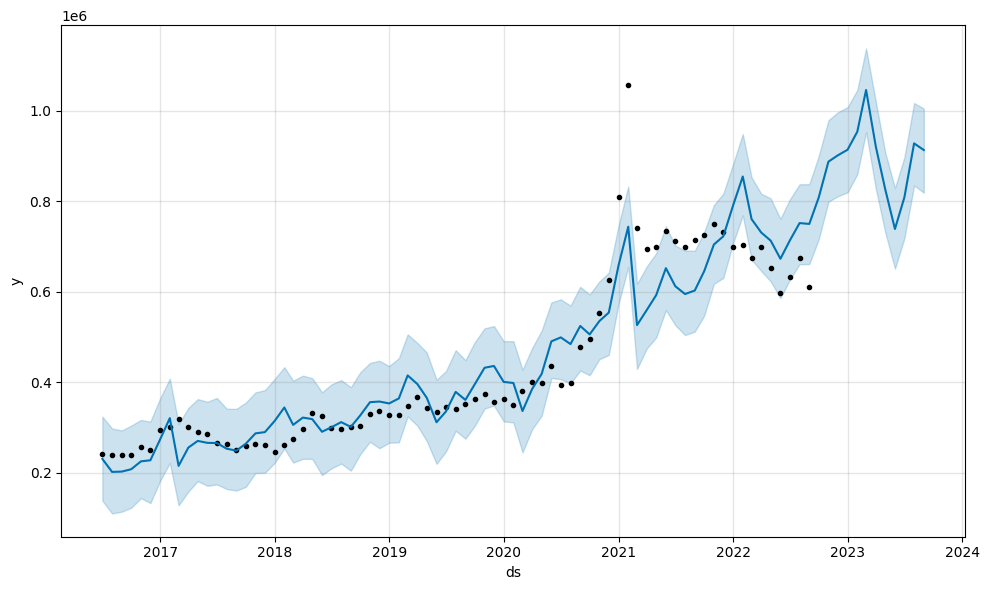

In [71]:
# plotting forecast
fig = model.plot(forecast)
print(county)

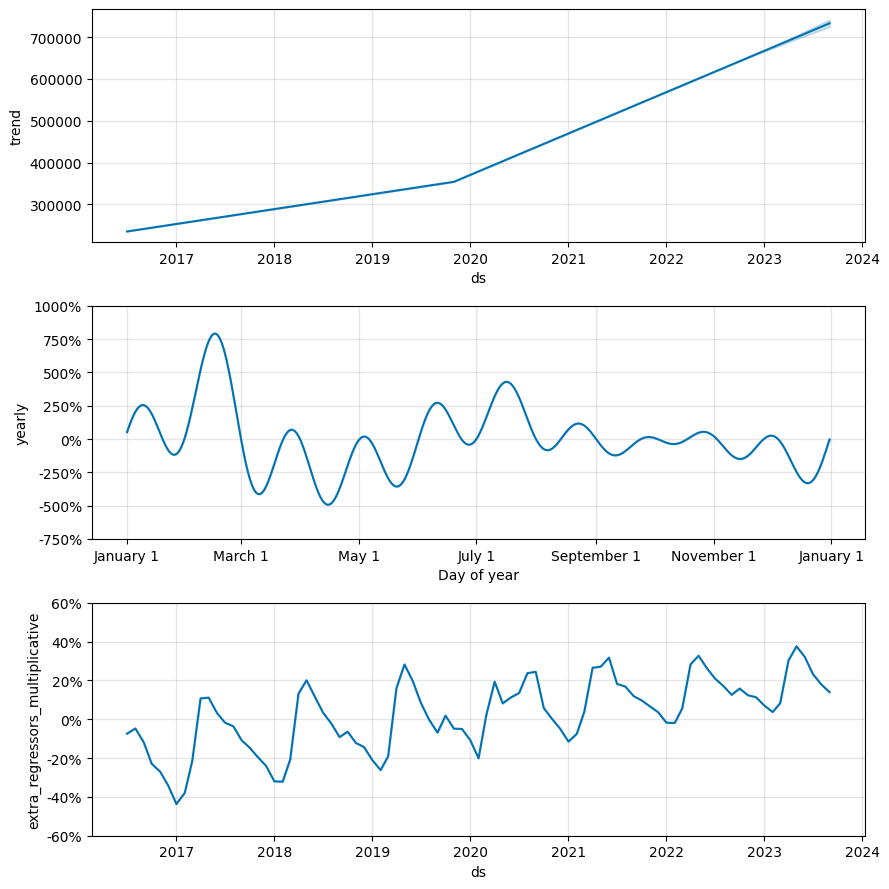

In [72]:
f = model.plot_components(forecast)

In [92]:
forecast.loc[forecast.ds == '2022-09-01']['yhat'].values[0]

750122.9537734998

In [93]:
# take output of forecast
# get values from after Oct 2022 onward 

def red_light_green_light(forecasts):
    # get current price Sept 2022
    last_known_price = forecast.loc[forecast.ds == '2022-09-01']['yhat'].values[0]

    five_percent_delta = last_known_price*0.05

    last_known_price_minus_five_percent = last_known_price - (last_known_price * five_percent_delta)

    last_known_price_plus_five_percent = last_known_price + (last_known_price * five_percent_delta)

    # get projected price Sept 2023

    one_year_projection = forecast.loc[forecast.ds == '2023-09-01']['yhat'].values[0]

    if last_known_price_minus_five_percent < one_year_projection < last_known_price_plus_five_percent:
        return 'staying level'
    
    elif one_year_projection <= last_known_price:
        return 'red light' 

    else:
        return 'green light'




In [73]:
# TO DO - how to evalute prophet model https://facebook.github.io/prophet/docs/diagnostics.html

In [74]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

cutoffs = pd.date_range(start='2020-09-01', end='2022-03-01', freq='6MS')
print(cutoffs)



df_cv = cross_validation(model, initial='1460 days', cutoffs=cutoffs, horizon = '180 days')
df_p = performance_metrics(df_cv)
df_p.head()

DatetimeIndex(['2020-09-01', '2021-03-01', '2021-09-01', '2022-03-01'], dtype='datetime64[ns]', freq='6MS')


  0%|          | 0/4 [00:00<?, ?it/s]

16:47:53 - cmdstanpy - INFO - Chain [1] start processing
16:47:54 - cmdstanpy - INFO - Chain [1] done processing
16:47:54 - cmdstanpy - INFO - Chain [1] start processing
16:47:54 - cmdstanpy - INFO - Chain [1] done processing
16:47:55 - cmdstanpy - INFO - Chain [1] start processing
16:47:55 - cmdstanpy - INFO - Chain [1] done processing
16:47:56 - cmdstanpy - INFO - Chain [1] start processing
16:47:56 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,6.709869e+09,81913.792442,79419.595833,0.128566,0.128566,0.127986,0.00
1,31 days,1.528779e+10,123643.806082,100609.075495,0.144029,0.144029,0.130061,0.50
2,61 days,1.049711e+10,102455.392939,93491.884436,0.145361,0.162282,0.146352,0.25
3,91 days,3.105182e+10,176215.276452,170820.729464,0.258198,0.258198,0.286517,0.00
4,92 days,1.546515e+10,124358.957161,88031.779781,0.147180,0.147180,0.128329,0.50


In [75]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-10-01,435640.244396,413981.971047,4.572746e+05,495000.0,2020-09-01
1,2020-11-01,428447.401191,407169.644688,4.509335e+05,553600.0,2020-09-01
2,2020-12-01,411661.476040,389601.374176,4.321110e+05,625750.0,2020-09-01
3,2021-01-01,425164.252076,403468.335912,4.460341e+05,810000.0,2020-09-01
4,2021-02-01,451303.638634,429847.492531,4.747891e+05,1058500.0,2020-09-01
5,2021-04-01,724486.934088,677277.142954,7.757199e+05,695750.0,2021-03-01
6,2021-05-01,721465.482728,675085.960883,7.721992e+05,699900.0,2021-03-01
7,2021-06-01,734443.542237,687345.498501,7.838498e+05,734250.0,2021-03-01
8,2021-07-01,679679.478463,630350.283351,7.323641e+05,712500.0,2021-03-01
9,2021-08-01,736934.611338,687478.881996,7.899556e+05,699945.0,2021-03-01


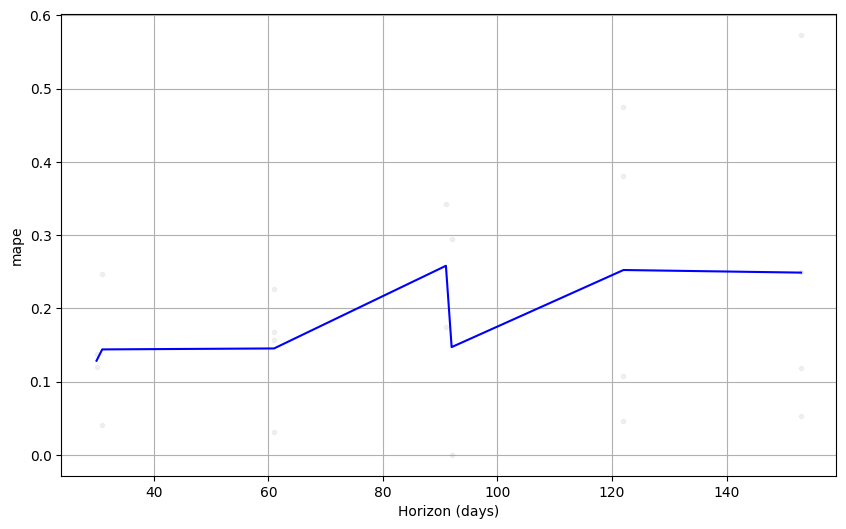

In [76]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
